In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from joblib import load
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src import plotting

In [2]:
data_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
all_train_df = pd.read_csv(f'{data_dir}/p.train.csv')
all_test_df = pd.read_csv(f'{data_dir}/p.test.csv')
all_holdout_df = pd.read_csv(f'{data_dir}/p.20230101.csv')

In [3]:
model_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/p_models/selected_features_constHP'
preds_2023 = pd.read_csv(os.path.join(model_dir, 'YHH.P.preds.holdout.csv'))
scaler = load(os.path.join(model_dir, 'YHH.P.scaler.joblib'))

In [4]:
preds_2023['residual'] = preds_2023['magnitude'] - preds_2023['predicted_magnitude']

In [5]:
stat = "YHH"
proc = GatherFeatureDatasets(is_p=True)
station_feature_dict, station_meta_dict, feature_names = proc.process_station_datasets(stat, 
                                                                                        all_train_df,
                                                                                        test_df=all_test_df,
                                                                                        holdout_df=all_holdout_df,
                                                                                        scaler=False,
                                                                                        linear_model=False,
                                                                                        source_dist_type='dist')

YHH
X shape: (4813, 45), y shape: (4813,)
X shape: (1215, 45), y shape: (1215,)
X shape: (397, 45), y shape: (397,)


In [6]:
feature_plot_names = proc.get_feature_plot_names(18, 'dist')

In [7]:
selected_features = np.array(['amp_1', 'amp_2','signal_variance',
                    'noise_variance', 'source_depth_km',
                    'source_receiver_distance_logkm',
                    'source_receiver_back_azimuth_deg'])
feature_inds = np.where(np.isin(feature_names, selected_features))[0]

In [8]:
train_means = station_feature_dict['X_train'][:, feature_inds].mean(axis=0)
holdout_means = station_feature_dict['X_holdout'][:, feature_inds].mean(axis=0)

In [9]:
train_means

array([ -3.89741442,  -3.00081907,  -1.64475404,  -8.18726973,
         7.41614378,   2.55442248, 190.25706984])

In [10]:
holdout_means

array([ -3.98976192,  -3.14251596,  -1.83551754,  -9.52720692,
         7.14715365,   2.60440415, 190.1382647 ])

In [11]:
X_train = station_feature_dict['X_train']
X_holdout = station_feature_dict['X_holdout']

In [12]:
SMALL_SIZE=8
MEDIUM_SIZE=9
LARGE_SIZE=9
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title
plt.rc('figure', labelsize=MEDIUM_SIZE)

In [13]:
def plot_features(X_train, 
                  y_train, 
                  X_test, 
                  y_test, 
                  test_evids,
                  test_preds, 
                  feature_inds,
                  feature_plot_names,
                  savefigname=None):
    fig, axes = plt.subplots(2, 4, constrained_layout=True, figsize=(6, 3))
    axes = axes.flatten()
    i = 0
    subpanel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)"]
    sp_ind = 0
    for find in feature_inds:
        ax = axes[i]
        if i == 3:
            ax.axis('off')
            i += 1
            ax = axes[i]
        s1 = ax.scatter(y_train, X_train[:, find], s=20, alpha=0.1, color='#737373', label='Train')
        good_ind = np.where(np.isin(test_evids, test_preds[abs(test_preds.residual) <= 0.5].Evid))
        bad_ind = np.where(np.isin(test_evids, test_preds[abs(test_preds.residual) > 0.5].Evid))
        s2 = ax.scatter(y_test[good_ind], X_test[good_ind, find], s=20, facecolors='none', edgecolor='k',
                   label='Test B')
        s3 = ax.scatter(y_test[bad_ind], X_test[bad_ind, find], s=20, facecolors='none', edgecolor='#fc9272', 
                    label='Test B - large resid.')
        if i == 0:
            legend_items = [s1, s2, s3]
        ax.set_title(feature_plot_names[find])
        #ax.set_yticklabels([])
        ax.set_xticks(np.arange(0, 5))
        if i < 4:
            ax.set_xticklabels([])

        ax.text(0, 1.04, subpanel_labels[sp_ind], 
        transform=ax.transAxes,)
        sp_ind += 1
        i += 1

    axes[3].legend(legend_items, 
                   ['Train', 'Test B', 'Test B,\n|resid.| > 0.5'], 
                   loc='center',
                   handletextpad=0.2, borderpad=0.2, handlelength=1.0,
                   labelspacing=1.0)

    fig.supxlabel('$M_{L,YP21}$')
    fig.supylabel("Feature Value")



    if savefigname is not None:
        fig.savefig(savefigname, dpi=300)

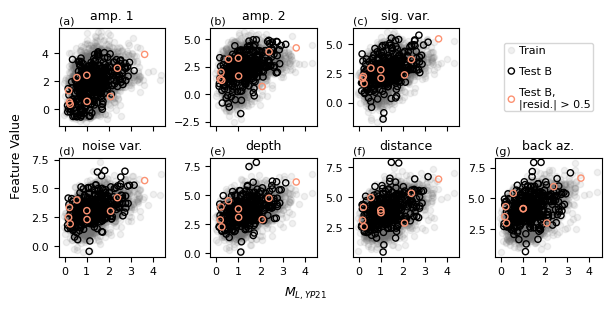

In [14]:
plot_features(X_train, station_meta_dict['y_train'], 
              X_holdout, station_meta_dict['y_holdout'], 
              station_meta_dict['evids_holdout'], preds_2023,
              np.arange(0, 7), feature_plot_names[feature_inds],
              savefigname=f'../figures/examineFeatureDist{stat}.png')

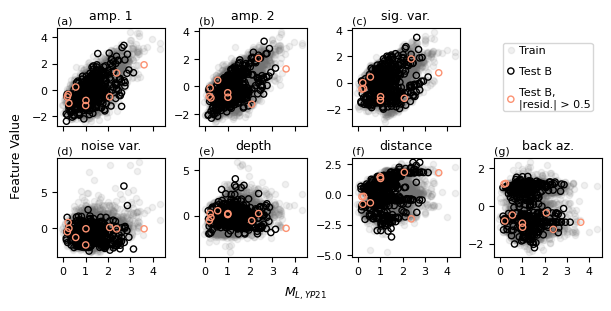

In [15]:
X_train_s = scaler.transform(X_train[:, feature_inds])
X_holdout_s = scaler.transform(X_holdout[:, feature_inds])
plot_features(X_train_s, station_meta_dict['y_train'], 
              X_holdout_s, station_meta_dict['y_holdout'], 
              station_meta_dict['evids_holdout'], preds_2023,
              np.arange(0, 7), feature_plot_names[feature_inds],
              savefigname=f'../figures/examineFeatureDists{stat}Scaled.png')

In [16]:
def plot_hist(X_train, 
                  X_test, 
                  test_evids,
                  test_preds, 
                  feature_inds,
                  feature_plot_names,
                  savefigname=None):
    fig, axes = plt.subplots(2, 4, constrained_layout=True, figsize=(6, 3))
    axes = axes.flatten()
    i = 0
    for find in feature_inds:
        ax = axes[i]
        if i == 3:
            ax.axis('off')
            i += 1
            ax = axes[i]
        ax.hist(X_train[:, find], color='#737373')
        good_ind = np.where(np.isin(test_evids, test_preds[test_preds.residual <= 0.5].Evid))
        bad_ind = np.where(np.isin(test_evids, test_preds[test_preds.residual > 0.5].Evid))
        ax.hist(X_test[bad_ind, find].flatten(), color='#fc9272')
        ax.hist(X_test[good_ind, find].flatten(), color='k')
        ax.set_title(feature_plot_names[find])
        #ax.set_yticklabels([])
        if i < 4:
            ax.set_xticklabels([])
        i += 1

    fig.supxlabel('Feature Value')
    fig.supylabel("Counts")

    if savefigname is not None:
        fig.savefig(savefigname, dpi=300)

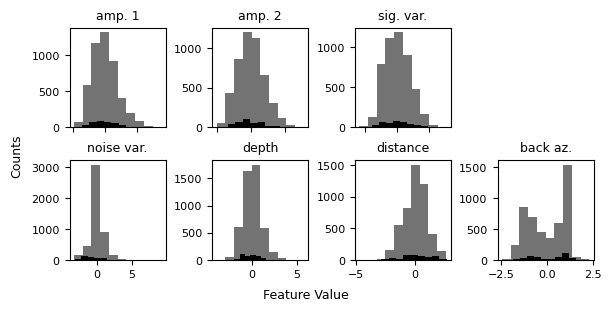

In [17]:
plot_hist(X_train_s,  
              X_holdout_s, 
              station_meta_dict['evids_holdout'], preds_2023,
              np.arange(0, 7), feature_plot_names[feature_inds])